# Three Bays Mangrove dNDVI Analysis, Artibonite, Haiti

In [1]:
import os
import json
import gc
import glob
import tarfile

import numpy as np
import xarray as xr
import earthpy as et 
import rasterio as rs
import rioxarray as rxr
import geopandas as gpd
import earthpy.plot as ep
import earthpy.spatial as es 
import matplotlib.pyplot as plt

from natsort import natsorted
from rasterio.plot import show
from datetime import datetime

Getting and sorting .tar file paths from Bulk Download Landsat Ph.D Data directory

In [2]:
data_dir = 'F:/PhD Data/Landsat 8 OLI_TIRS C2 L1/*.tar'
tarpaths = []
# Suffixes and Prefixes to clean to easily sort by observation date 
sf1 = '_02_T1.tar'
sf2 = '_02_T2.tar'
pf1 = 'F:/PhD Data/Landsat 8 OLI_TIRS C2 L1\LC08_L1GT_009047_'
pf2 = 'F:/PhD Data/Landsat 8 OLI_TIRS C2 L1\LC08_L1TP_009047_'
pf3 = 'F:/PhD Data/Landsat 8 OLI_TIRS C2 L1\LC08_L1TP_009046_'
pf4 = 'F:/PhD Data/Landsat 8 OLI_TIRS C2 L1\LO08_L1GT_009047_'
# Parse through .tar files in folder
for filepath in glob.iglob(data_dir):
    tarpaths.append(filepath)

# Returns observation date
def rm_prefsuf(x):
    return ((x.removesuffix(sf1)).removesuffix(sf2).removeprefix(pf1).removeprefix(pf2).removeprefix(pf3).removeprefix(pf4))[:-9]

# Sort list of paths by observation dates
tarpaths = natsorted(tarpaths, key=lambda x: datetime.strptime(rm_prefsuf(x), '%Y%m%d'))

## dNDVI Analysis - 2013 to 2021

Retrieving .tar bands from early and recent observations

In [3]:
rs.Env(VRT_SHARED_SOURCE = 0)

path2013 = tarpaths[0]
path2021 = tarpaths[-1]
# Only grab bands 1 through 5
wanted = ['B1.TIF', 'B2.TIF', 'B3.TIF', 'B4.TIF', 'B5.TIF', 'MTL.json']

# First observation
archive1 = tarfile.open(path2013, 'r')
archive1.getmembers()
band_files_13 = []
for file in archive1.getmembers():
    #print(file.name + ': ' + str(file.name.endswith(tuple(wanted))))
    if file.name.endswith(tuple(wanted)):
        band_files_13.append(file)
        file.uname
band_files_13 = natsorted(band_files_13, key=lambda x: x.name)

# Last observation
archive2 = tarfile.open(path2021, 'r')
archive2.getmembers()
band_files_21 = []
for file in archive2.getmembers():
    if file.name.endswith(tuple(wanted)):
        band_files_21.append(file)
        file.uname
band_files_21 = natsorted(band_files_21, key=lambda x: x.name)

### [2013 Data] Extract band files for temporary use (only Bands 1 to 5) and stack in Dataset

Extent of mangrove forest for cropping

In [4]:
bay_p = '../shapefiles/horn.shp'
bay_boundary = gpd.read_file(bay_p)

DriverError: shapefiles/horn.shp: No such file or directory

Bands extraction

In [ ]:
for f in band_files_13:
    archive1.extract(f, path='extracted/')

# Stack bands in list and open metadata
bands13 = []

directory = 'extracted/'
# Looping over all GeoTIFF files
for i, entry in enumerate(os.scandir(directory)):
    # Tries to open .TIF file, if that fails, know we reached the .json metadata file and get that instead
    try:
        fp = entry.path
        # Open and crop bands to mangrove extent
        bands13.append(rxr.open_rasterio(fp).rio.clip(bay_boundary.geometry, from_disk=True).squeeze())
        bands13[i]["Band"] = i+1
    except:
        metadata = json.load(open(entry.path))

(DISABLED TOA CALCULATIONS FOR NOW) Process and rescale bands using metadata (TOA Calculation)

In [ ]:
#for i, band in enumerate(bands13[0:-1]):
 #   M_p = metadata['LANDSAT_METADATA_FILE'] \
  #                  ['LEVEL1_RADIOMETRIC_RESCALING'] \
   #                 ['REFLECTANCE_MULT_BAND_{}'.format(i+1)]
    #A_p = metadata['LANDSAT_METADATA_FILE'] \
     #               ['LEVEL1_RADIOMETRIC_RESCALING'] \
      #              ['REFLECTANCE_ADD_BAND_{}'.format(i+1)]
    #toa = float(M_p) * band.values + float(A_p)
    #bands13[i].values = toa

Stack bands and wipe temporary .tif files from directory

In [ ]:
ds13 = xr.concat(bands13, dim='Band')

Calculating NDVI

In [ ]:
nir = ds13[4].astype(float)
red = ds13[3].astype(float)
ndvi13= (nir - red) / (nir + red)

Plotting NDVI from 2013

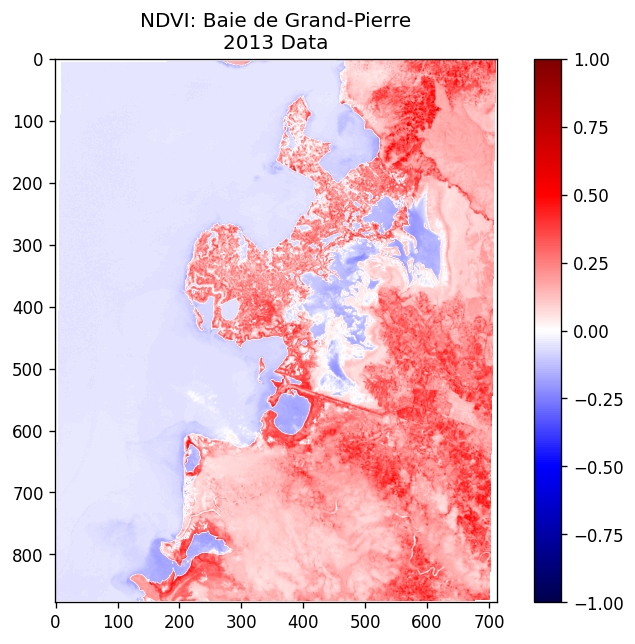

In [ ]:
plt.figure(figsize=(8, 6), dpi=120)
nd = plt.imshow(ndvi13, vmin=-1, vmax=1)
plt.title("NDVI: Baie de Grand-Pierre\n2013 Data")
plt.set_cmap('seismic')
plt.colorbar(nd)
plt.show()

Cleaning up variables and deleting .tiff files for 2013

In [ ]:
#del ds13, bands13
gc.collect()

for i, entry in enumerate(os.scandir(directory)):
    try:
        bands13[i].close()
        ds13[i].close()
        gc.collect()
        os.remove(entry.path)
    except Exception as e:
        try:
            gc.collect()
            os.remove(entry.path)
        except:
            print(e)
            print('cant delete ' + entry.path + '\nfile still in use')


### [2021 Data] Extract band files for temporary use (only Bands 1 to 5) and stack in Dataset

Bands Extraction

In [ ]:
for f in band_files_21:
    archive2.extract(f, path='extracted/')
# Stack bands in list and open metadata
bands21 = []
directory = 'extracted/'
# Looping over all GeoTIFF files
for i, entry in enumerate(os.scandir(directory)):
    # Tries to open .TIF file, if that fails, know we reached the .json metadata file and get that instead
    try:
        fp = entry.path
        # Open and crop bands to mangrove extent
        da = rxr.open_rasterio(fp).rio.clip(
    bay_boundary.geometry,
    from_disk=True).squeeze()
        bands21.append(da)
        bands21[i]["Band"] = i+1
    except:
        metadata = json.load(open(entry.path))

Stack bands and wipe temporary .tif files from directory

In [ ]:
ds21 = xr.concat(bands21, dim='Band')

del bands21
for entry in os.scandir(directory):
    try:
        os.remove(entry.path)
    except:
        print('cant delete ' + entry.path + '\nfile still in use')

cant delete extracted/LC08_L1TP_009047_20211111_20211117_02_T1_B1.TIF
file still in use
cant delete extracted/LC08_L1TP_009047_20211111_20211117_02_T1_B4.TIF
file still in use
cant delete extracted/LC08_L1TP_009047_20211111_20211117_02_T1_B5.TIF
file still in use


Calculating NDVI

In [ ]:
nir21 = ds21[4].astype(float)
red21 = ds21[3].astype(float)
ndvi21= (nir21 - red21) / (nir21 + red21)

Plotting data from 2021

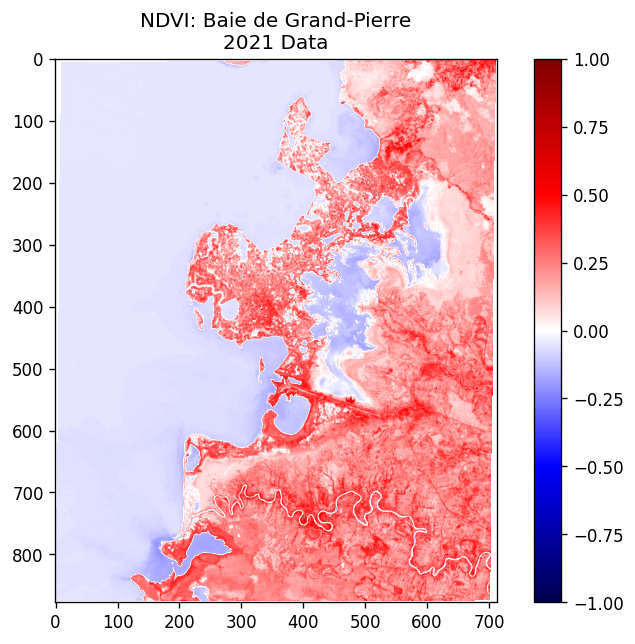

In [ ]:
plt.figure(figsize=(8, 6), dpi=120)
nd = plt.imshow(ndvi21, vmin=-1, vmax=1)
plt.title("NDVI: Baie de Grand-Pierre\n2021 Data")
plt.set_cmap('seismic')
plt.colorbar(nd)
plt.show()

### dNDVI Calculation and Plotting

<xarray.DataArray (y: 878, x: 713)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.45008208,
         0.20867055,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.45540483,
         0.26759531,  0.        ],
       ...,
       [-0.0538415 , -0.05393976, -0.05462692, ...,  0.        ,
         0.        ,  0.        ],
       [-0.05253154, -0.05295896, -0.05298585, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
  * x            (x) float64 7.277e+05 7.277e+05 7.277e+05 ... 7.49e+05 7.49e+05
  * y            (y) float64 2.152e+06 2.152e+06 ... 2.126e+06 2.126e+06
    band         int32 1
    spatial_ref  int32 0


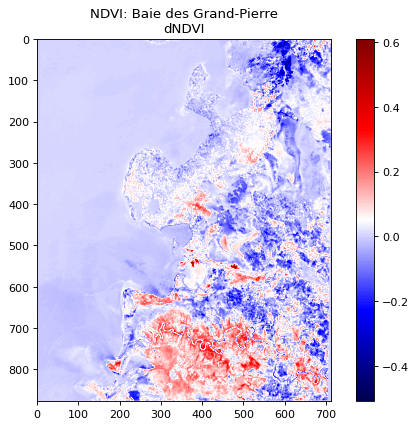

In [ ]:
ndvi13 = ndvi13.fillna(0)
ndvi21 = ndvi21.fillna(0)
dndvi = np.subtract(ndvi21, ndvi13)
print(ndvi21)
plt.figure(figsize=(8, 6), dpi=80)
nd = plt.imshow(dndvi)
plt.title("NDVI: Baie des Grand-Pierre\ndNDVI")
#plt.set_cmap('seismic')
plt.colorbar(nd)
plt.show()